In [216]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()
%matplotlib inline

In [217]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer
from darts.models import (
    CatBoostClassifierModel,
)

In [219]:
data_dir = "/Users/dennisbader/projects/unit8/darts_test_code/cat_forecasting/out"
fpaths = []
for el in os.walk(data_dir):
    for fname in el[2]:
        fpaths.append(os.path.join(data_dir, fname))

In [220]:
dfs = []
for fpath in fpaths:
    dfs.append(pd.read_csv(fpath).reset_index(names="time"))
df = pd.concat(dfs, ignore_index=True)

In [221]:
df

,time,x__number_peaks__n_3,x__number_peaks__n_5,x__number_peaks__n_1,x__approximate_entropy__m_2__r_0.1,x__approximate_entropy__m_2__r_0.3,x__number_crossing_m__m_0,x__number_crossing_m__m_1,x__number_crossing_m__m_-1,x__permutation_entropy__dimension_7__tau_1,...,x__permutation_entropy__dimension_3__tau_1,x__cid_ce__normalize_True,x__autocorrelation__lag_1,x__partial_autocorrelation__lag_1,x__friedrich_coefficients__coeff_2__m_3__r_30,"x__fft_aggregated__aggtype_""centroid""","x__fft_aggregated__aggtype_""skew""",x__quantile__q_0.3,name,y
0,0,315.0,205.0,877.0,1.464203,0.755435,419.0,399.0,431.0,7.188947,...,1.770833,19.949932,0.933906,0.933906,-0.126043,378.032470,1.131395,-8.111427,SC4181E0,0
1,1,282.0,189.0,781.0,1.244038,0.552865,276.0,280.0,262.0,6.770892,...,1.746526,17.378288,0.949935,0.949935,-0.064315,367.286132,1.199818,-11.085714,SC4181E0,0
2,2,253.0,177.0,783.0,1.222239,0.544160,269.0,261.0,247.0,6.673804,...,1.748141,14.303632,0.965318,0.965318,-0.056732,313.374723,1.490288,-14.342857,SC4181E0,0
3,3,280.0,185.0,812.0,1.261688,0.538501,284.0,280.0,290.0,6.855837,...,1.756806,13.945223,0.967011,0.967011,-0.065927,313.436505,1.474988,-11.454285,SC4181E0,0
4,4,290.0,173.0,817.0,1.301207,0.581439,351.0,367.0,345.0,6.961605,...,1.761146,15.675449,0.958469,0.958469,-0.081870,345.925353,1.265446,-12.397141,SC4181E0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34321,1139,302.0,193.0,874.0,1.605372,0.930169,495.0,485.0,499.0,7.133459,...,1.773600,23.535263,0.907654,0.907654,-0.185265,412.182637,0.996741,-15.763442,SC4161E0,0
34322,1140,306.0,187.0,859.0,1.650575,0.949919,465.0,479.0,469.0,7.126156,...,1.770991,23.207407,0.910518,0.910518,-0.174722,407.867191,1.028380,-15.642490,SC4161E0,0
34323,1141,313.0,186.0,846.0,1.540277,0.836100,435.0,435.0,439.0,7.072735,...,1.768787,20.253965,0.931781,0.931781,-0.099417,381.127540,1.124630,-19.392014,SC4161E0,0
34324,1142,301.0,190.0,834.0,1.464508,0.719628,465.0,465.0,455.0,7.015979,...,1.766032,17.688297,0.947951,0.947951,-0.129694,361.585131,1.206329,-19.112892,SC4161E0,0


In [222]:
data = TimeSeries.from_group_dataframe(
    df, time_col="time", group_cols="name", metadata_cols="name"
)

In [223]:
sct = StaticCovariatesTransformer(cols_cat=["name"])
data = sct.fit_transform(data)

In [224]:
series = [s["y"] for s in data]
covs = [s[s.columns.drop(["y"]).tolist()[:10]] for s in data]

In [225]:
len(series), len(covs)

(31, 31)

In [226]:
num_val = 4
num_test = 3

In [227]:
series_train, series_val, series_test = (
    series[: -(num_val + num_test)],
    series[-(num_val + num_test) : -num_test],
    series[-num_test:],
)
covs_train, covs_val, covs_test = (
    covs[: -(num_val + num_test)],
    covs[-(num_val + num_test) : -num_test],
    covs[-num_test:],
)

In [228]:
for cov in covs:
    print(cov.shape)

(841, 10, 1)
(1127, 10, 1)
(1103, 10, 1)
(1186, 10, 1)
(1025, 10, 1)
(1009, 10, 1)
(952, 10, 1)
(1235, 10, 1)
(1200, 10, 1)
(1246, 10, 1)
(843, 10, 1)
(1016, 10, 1)
(1273, 10, 1)
(1134, 10, 1)
(1054, 10, 1)
(1105, 10, 1)
(1104, 10, 1)
(1092, 10, 1)
(928, 10, 1)
(1052, 10, 1)
(977, 10, 1)
(1028, 10, 1)
(1004, 10, 1)
(952, 10, 1)
(1762, 10, 1)
(1144, 10, 1)
(1003, 10, 1)
(1773, 10, 1)
(964, 10, 1)
(920, 10, 1)
(1274, 10, 1)


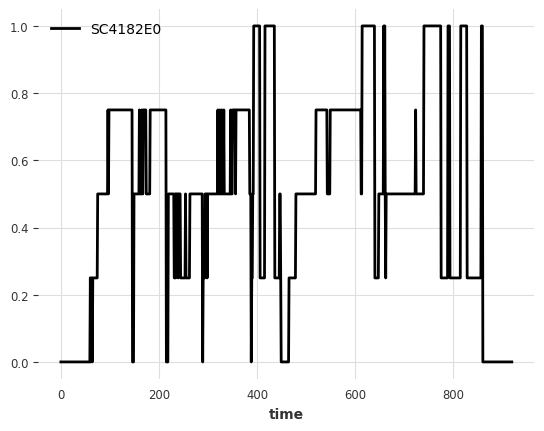

In [229]:
idx = 0
for s in series:
    if not s.metadata["name"] == "SC4182E0":
        continue
    Scaler().fit_transform(s).plot(label=s.metadata["name"])
# Scaler().fit_transform(covs[0]).plot()

In [230]:
model_cls = CatBoostClassifierModel

In [231]:
def n_hours_of_sleep(idx):
    return idx.values // 60

In [239]:
model = model_cls(
    lags=None,
    lags_future_covariates=(5, 1),
    output_chunk_length=1,
    use_static_covariates=True,
    add_encoders={"custom": {"future": [n_hours_of_sleep]}},
)

In [240]:
covs_train[0].shape, covs_val[0].shape

((841, 10, 1), (1762, 10, 1))

In [241]:
model.fit(
    series=series_train,
    future_covariates=covs_train,
    val_series=series_val,
    val_future_covariates=covs_val,
)

CatBoostClassifierModel(lags=None, lags_past_covariates=None, lags_future_covariates=(5, 1), output_chunk_length=1, output_chunk_shift=0, add_encoders={'custom': {'future': [<function n_hours_of_sleep at 0x16b77d1c0>]}}, likelihood=classprobability, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

In [242]:
preds = model.historical_forecasts(
    series=series_test,
    future_covariates=covs_test,
    forecast_horizon=1,
    retrain=False,
    # predict_likelihood_parameters=True,
)

/Users/dennisbader/projects/unit8/darts/darts/utils/data/tabularization/tabularization.py:1720: UserWarning: `target_series` was specified without accompanying `lags` and, thus, will be ignored.
  warnings.warn(


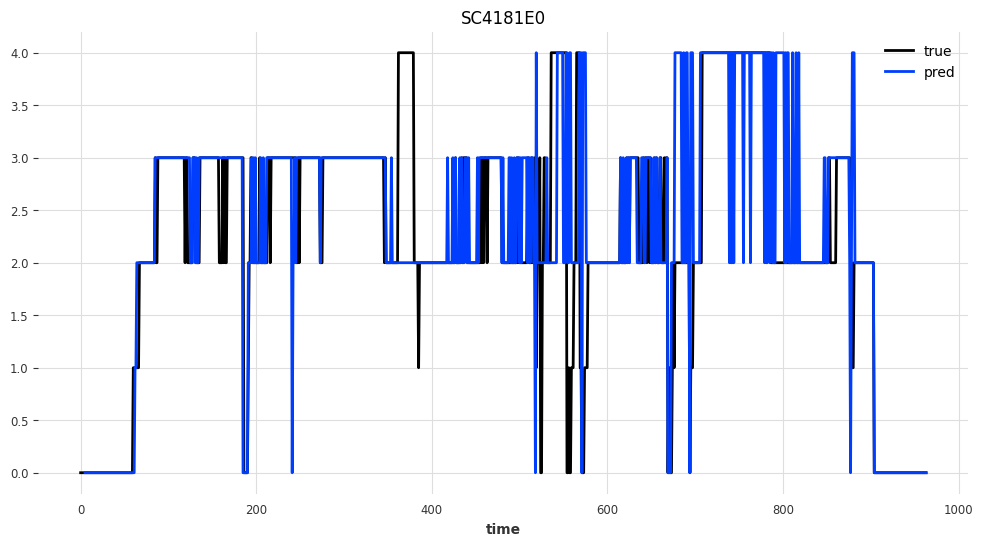

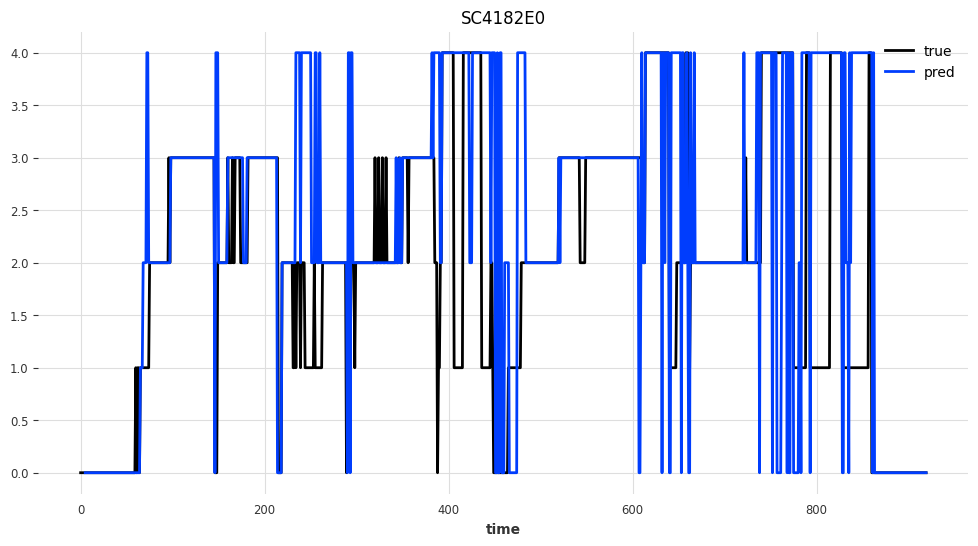

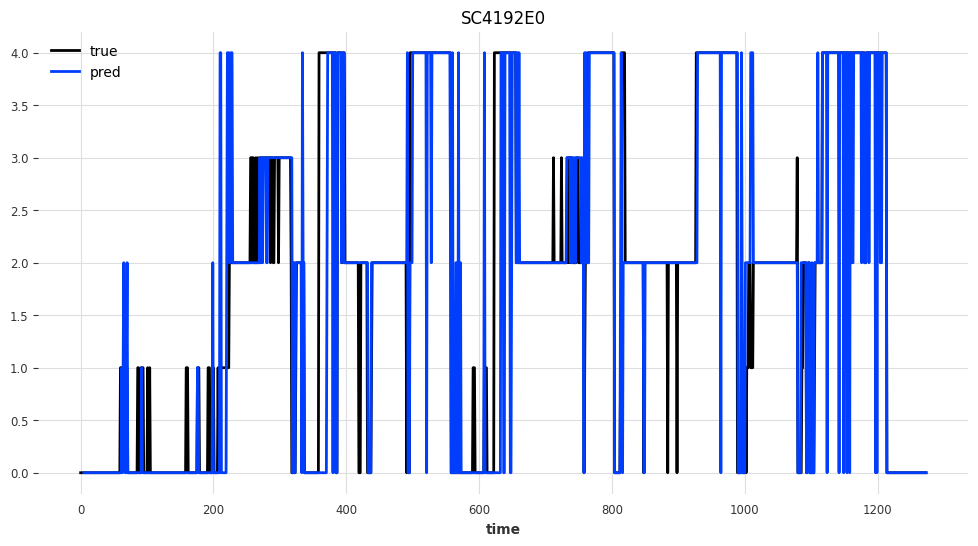

In [243]:
for s, p in zip(series_test, preds):
    fig, ax = plt.subplots(figsize=(12, 6))
    s.plot(label="true", ax=ax)
    p.plot(label="pred", ax=ax)
    ax.set_title(s.metadata["name"])
    plt.show()

In [244]:
y_true = []
y_pred = []
for s, p in zip(series_test, preds):
    y_true.append(s.slice_intersect(p).to_dataframe())
    y_pred.append(p.slice_intersect(s).to_dataframe())
y_true = pd.concat(y_true)
y_pred = pd.concat(y_pred)

In [245]:
(y_true == y_pred).mean()

y    0.793191
dtype: float64

In [246]:
preds_lkl = model.historical_forecasts(
    series=series_test,
    future_covariates=covs_test,
    forecast_horizon=1,
    retrain=False,
    predict_likelihood_parameters=True,
)

/Users/dennisbader/projects/unit8/darts/darts/utils/data/tabularization/tabularization.py:1720: UserWarning: `target_series` was specified without accompanying `lags` and, thus, will be ignored.
  warnings.warn(


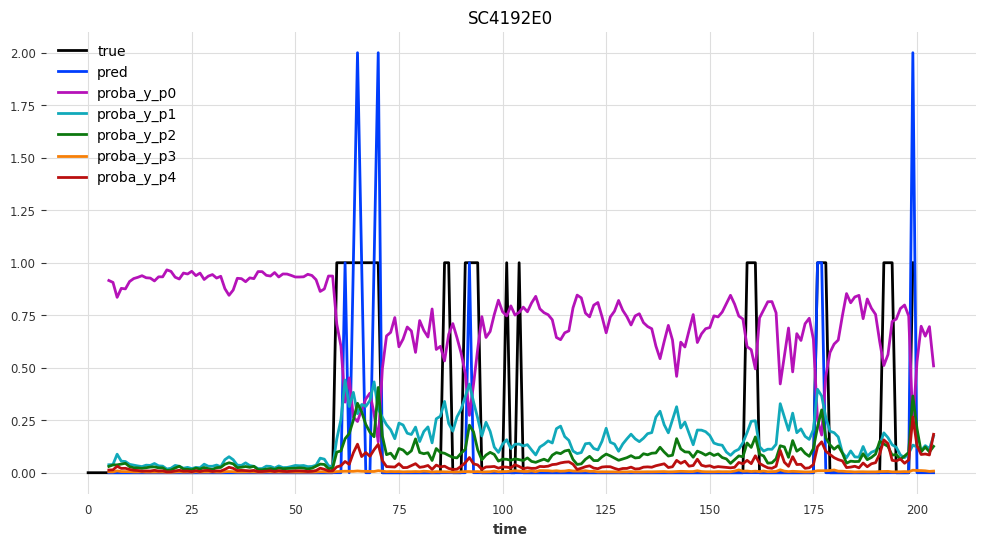

In [250]:
for s, p, p_lkl in zip(series_test[-1:], preds[-1:], preds_lkl[-1:]):
    fig, ax = plt.subplots(figsize=(12, 6))
    s[:200].plot(label="true", ax=ax)
    p[:200].plot(label="pred", ax=ax)
    p_lkl[:200].plot(label="proba", ax=ax)
    ax.set_title(s.metadata["name"])
    plt.show()